In [1]:
import numpy as np
import nibabel as nib
from nilearn import plotting
from src.connectivity_functions import *
from src.tree_functions import *
from src.ni_functions import *
from src.plotting_functions import plot_corr
import seaborn as sns
from src.io_functions import load_data
import os
import json
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram, leaves_list
from matplotlib import colors

In [2]:
project_path = "/workspaces/bha2"
conn_size = 2165

In [3]:
if os.path.exists(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy")):
    fcm = np.load(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy"))
    scm = np.load(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_scm.npy"))
    print("fcm and scm loaded from tmp folder")
else:
    sc_group = load_data(
        os.path.join(project_path, "data", "raw", "n" + str(conn_size), "sc")
    )
    fc_group = load_data(
        os.path.join(project_path, "data", "raw", "n" + str(conn_size), "fc")
    )
    fcm, scm = connectome_average(fc_group, sc_group)
    np.save(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy"), fcm)
    np.save(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_scm.npy"), scm)

fcm and scm loaded from tmp folder


In [4]:
zero_rows_sc = np.where(~scm.any(axis=1))[0]
fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(zero_rows_sc, fcm, scm)
density = np.where(scm_nonzero.flatten() > 0, 1, 0).sum(dtype=float) / (
    len(scm_nonzero.flatten())
)
fcm_thr = density_threshold(fcm_nonzero, density)
zero_rows_fc = np.where(~fcm_thr.any(axis=1))[0]
fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(
    zero_rows_fc, fcm_thr, scm_nonzero
)
fcm_bin = np.where(abs(fcm_nonzero) > 0, 1, 0)
scm_bin = np.where(scm_nonzero > 0, 1, 0)

print("connectome density = " + str(density))

connectome density = 0.07191603968863612


In [5]:
OPT_GAMMA = 0.7
OPT_LEVEL = 28
SM_THRESH = 5

tree = json.loads(
    open(
        os.path.join(
            project_path,
            "data",
            "processed",
            "n" + str(conn_size),
            "tree_g_" + str(OPT_GAMMA) + ".json",
        )
    ).read()
)
level, labels = level_from_tree(tree, OPT_LEVEL)
level_sizes = np.array([len(l) for l in level])
levels_valid = np.array(level)[np.where(level_sizes>SM_THRESH)[0].tolist()]

sim = similarity_level(fcm_bin, scm_bin, levels_valid)

sc_localmod = []
fc_localmod = []
mod_size = []
mxmod = []

for idx, mod in enumerate(levels_valid):
    sc_localmod.append(local_modularity(scm_bin, mod))
    fc_localmod.append(local_modularity(fcm_bin, mod))
    mod_size.append(len(mod))
    mxmod.append(pow((sim[idx] * sc_localmod[idx] * fc_localmod[idx]), (1 / 3)))

/tmp/ipykernel_707082/4061084750.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  levels_valid = np.array(level)[np.where(level_sizes>SM_THRESH)[0].tolist()]


In [6]:
color_list = []
for name, hex in colors.cnames.items():
    rgb = colors.hex2color(hex)
    L = pow((pow(rgb[0], 2) + pow(rgb[1], 2) + pow(rgb[2], 2)), 0.5) / pow(3, 0.5)
    if L < 0.85:
        color_list.append(name)
np.random.seed(3)
color_list = list(np.random.choice(color_list, OPT_LEVEL, replace=False))
#remove from the list colors corresponding to one-roi modules
color_list_ni = np.delete(color_list, np.where(level_sizes < SM_THRESH)[0]).tolist()

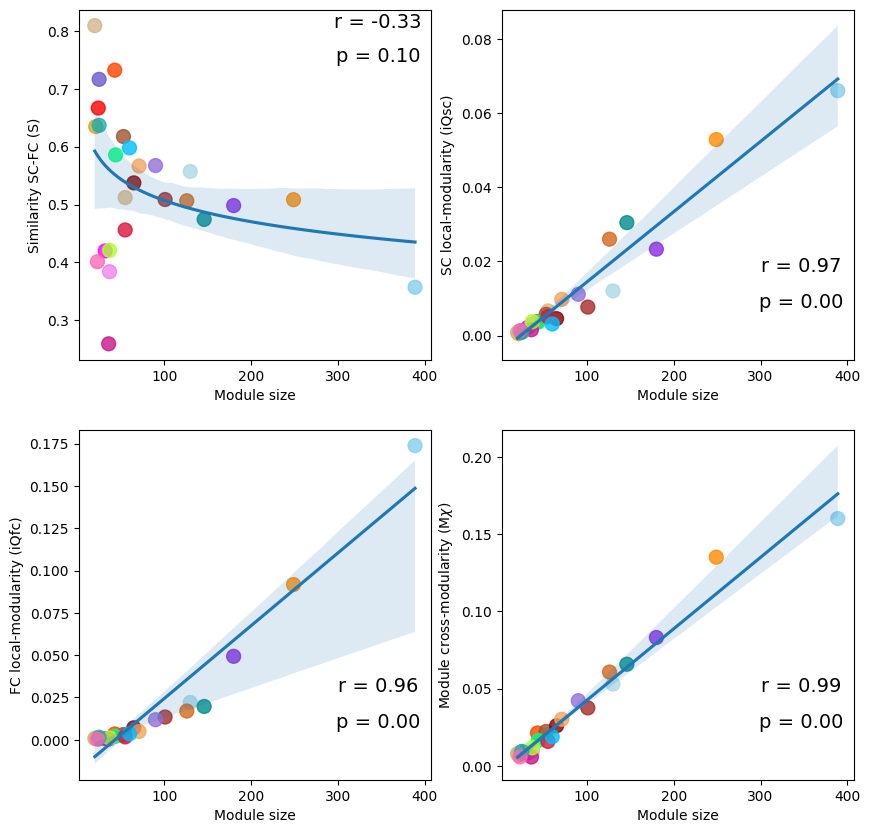

In [8]:
# represent in a three-panel subplot the scatters between sim and mod_size, sc_intramod and mod_size, fc_intramod and mod_size, xmod and mod_size
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

sns.regplot(mod_size, sim, logx=True, scatter_kws={'alpha':0.8, 's': 100, 'color': color_list_ni}, ax=axes[0, 0])
axes[0, 0].set_xlabel("Module size")
axes[0, 0].set_ylabel("Similarity SC-FC (S)")
plot_corr(mod_size, sim, 0.85, 0.85, ax=axes[0, 0])

sns.regplot(mod_size, sc_localmod, scatter_kws={'alpha':0.8, 's': 100, 'color': color_list_ni}, ax=axes[0, 1])
axes[0, 1].set_xlabel("Module size")
axes[0, 1].set_ylabel("SC local-modularity (iQsc)")
plot_corr(mod_size, sc_localmod, 0.85, 0.15, ax=axes[0, 1])

sns.regplot(mod_size, fc_localmod, scatter_kws={'alpha':0.8, 's': 100, 'color': color_list_ni}, ax=axes[1, 0])
axes[1, 0].set_xlabel("Module size")
axes[1, 0].set_ylabel("FC local-modularity (iQfc)")
plot_corr(mod_size, fc_localmod, 0.85, 0.15, ax=axes[1, 0])

sns.regplot(mod_size, mxmod, scatter_kws={'alpha':0.8, 's': 100, 'color': color_list_ni}, ax=axes[1, 1])
axes[1, 1].set_xlabel("Module size")
axes[1, 1].set_ylabel("Module cross-modularity (M" + r"$\chi$" +")")
plot_corr(mod_size, mxmod, 0.85, 0.15, ax=axes[1, 1])


plt.savefig(
    os.path.join(
        project_path,
        "data",
        "figures",
        "module_xmod_measures.svg",
    ),
    dpi=300,
    bbox_inches="tight",
    format="svg",
)